# Analyzing NYC High School Data

In [1]:
%matplotlib inline

In [2]:
# Read in the data
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
coor_sat_score = combined.corr().loc[survey_fields, "sat_score"]

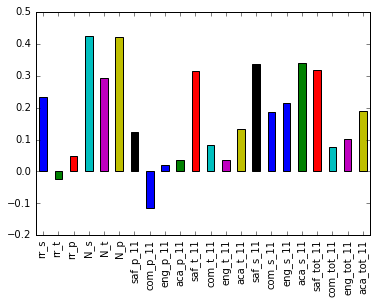

In [13]:
coor_sat_score.plot.bar(x = survey_fields, y = "corr_to_sat_score")

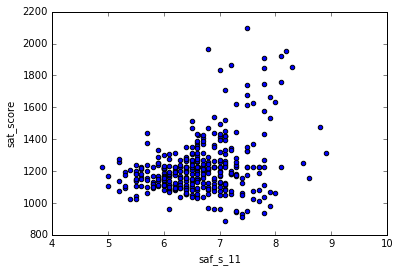

In [14]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

In [29]:
combined.info(all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Data columns (total 160 columns):
DBN                                     object
SCHOOL NAME                             object
Num of SAT Test Takers                  object
SAT Critical Reading Avg. Score         float64
SAT Math Avg. Score                     float64
SAT Writing Avg. Score                  float64
sat_score                               float64
SchoolName                              object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
Demographic                             object
School Name                             object
Cohort                                  object
Total Cohort                            float64
Total Grads - n                         object
Total Grads - % of cohort               object
Total Regents - n                       object
Total Regents - % of cohort             

In [16]:
averege_sft_score = combined.groupby('school_dist')[['saf_tot_11', 'lat', 'lon']].mean()

In [17]:
averege_sft_score

,saf_tot_11,lat,lon
school_dist,,,
01,7.433333,40.719022,-73.982377
02,7.520833,40.739699,-73.991386
03,7.233333,40.781574,-73.977370
04,7.714286,40.793449,-73.943215
05,7.085714,40.817077,-73.949251
06,7.660000,40.848970,-73.932502
07,7.392308,40.816815,-73.919971
08,7.218182,40.823803,-73.866087
09,7.365000,40.836349,-73.906240


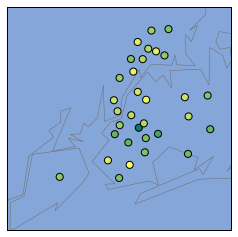

In [18]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = averege_sft_score["lon"].tolist()
latitudes = averege_sft_score["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=averege_sft_score["saf_tot_11"], cmap="summer")


In [19]:
coor_sat_score_gen = combined.corr().loc[['male_per', 'female_per'], "sat_score"]

In [21]:
coor_sat_score_gen

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

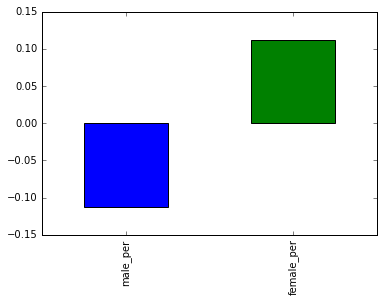

In [20]:
coor_sat_score_gen.plot.bar(x = ['male_per', 'female_per'], y = "corr_to_sat_score")

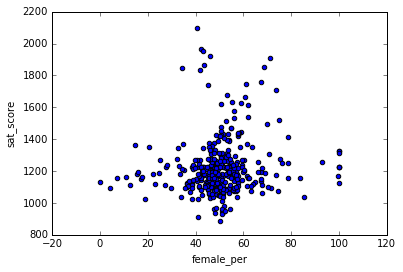

In [22]:
combined.plot.scatter(x='female_per', y='sat_score')

In [41]:
shoos1 = combined[(combined['female_per']>0.6) & (combined['sat_score']>1700)]['SCHOOL NAME'].reset_index(drop=True)

In [42]:
type(shoos1)
print(shoos1)

0                        BARD HIGH SCHOOL EARLY COLLEGE
1                         ELEANOR ROOSEVELT HIGH SCHOOL
2                                STUYVESANT HIGH SCHOOL
3                                    BEACON HIGH SCHOOL
4     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
5     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
6                          BRONX HIGH SCHOOL OF SCIENCE
7     HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
8                        BROOKLYN TECHNICAL HIGH SCHOOL
9                            BROOKLYN LATIN SCHOOL, THE
10                          TOWNSEND HARRIS HIGH SCHOOL
11    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
12                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [46]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

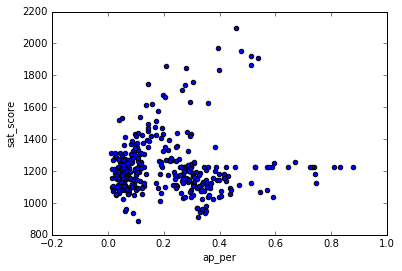

In [47]:
combined.plot.scatter(x='ap_per', y='sat_score')